# Visual prompting component implementation

In [ ]:
!pip install ultralytics

In [2]:
import torch
import numpy as np
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from transformers import AutoProcessor, LlavaForConditionalGeneration
import re
import textwrap

In [4]:
print(f"GPU available: {torch.cuda.is_available()}, Device: {torch.cuda.get_device_properties(torch.cuda.current_device()).name}")
device = torch.cuda.current_device()
print(device)

GPU available: True, Device: NVIDIA A100-SXM4-40GB
0


# Load models

In [5]:
yolo = YOLO("yolo11n.pt")

model_id = "llava-hf/llava-1.5-13b-hf"
model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
).to(device)

processor = AutoProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


# Object box

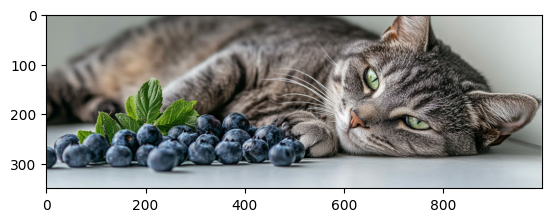

In [5]:
image = Image.open("./images/blueberry.png")
plt.imshow(image)
plt.show()

In [ ]:
results = yolo.predict(image)[0]
cat_cls = 15
object_boxes = [box for box in results.boxes if int(box.cls) == cat_cls]
object_box = object_boxes[0].xyxy[0].cpu().numpy().astype(int)

bounding_box_color = "blue"
object_name = "Blueberry"
object_type = "Cat"

image_with_rectangle = image.copy()
draw = ImageDraw.Draw(image_with_rectangle)
draw.rectangle(object_box.tolist(), outline=bounding_box_color, width=6)

plt.imshow(image_with_rectangle)
plt.show()

100%|██████████| 5.35M/5.35M [00:00<00:00, 64.6MB/s]


# Visual Prompt

## Simple cat example

In [ ]:
task = f"describe what {object_name} is doing?"
context = f"{object_name} is young and playful cat."
max_tokens = 300
prompt_template = f"In this image, the entity enclosed in a {bounding_box_color} box is called {object_name}. \
Without mentioning the bounding box and its color, {task}."
if len(context) > 0:
  prompt_template += f"[Optional] Give more details using the information from: {context}."

### Without Bounding Box

In [ ]:
conversation = [
    {

        "role": "user",
        "content": [
            {"type": "text", "text": task},
            {"type": "image"},
        ],
    },
]
prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
inputs = processor(images=image, text=prompt, return_tensors='pt').to(0, torch.float16)
output = model.generate(**inputs, max_new_tokens=200, temperature=0.9, do_sample=True)

plt.imshow(image)
llava_res = processor.decode(output[0], skip_special_tokens=True)
match = re.search(r"ASSISTANT:\s*(.*)", llava_res, re.DOTALL)
print(match.group(1).strip() if match else llava_res)

### With Bouding Box

In [ ]:
conversation = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": prompt_template},
            {"type": "image"},
        ],
    },
]

prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
inputs = processor(images=image_with_rectangle, text=prompt, return_tensors='pt').to(0, torch.float16)
output = model.generate(**inputs, max_new_tokens=200, temperature=0.9, do_sample=True)

plt.imshow(image_with_rectangle)
llava_res = processor.decode(output[0], skip_special_tokens=True)
match = re.search(r"ASSISTANT:\s*(.*)", llava_res, re.DOTALL)
print(match.group(1).strip() if match else llava_res)

## Group of people


0: 448x640 7 persons, 4 cups, 1 chair, 1 dining table, 1 laptop, 58.9ms
Speed: 33.1ms preprocess, 58.9ms inference, 375.6ms postprocess per image at shape (1, 3, 448, 640)


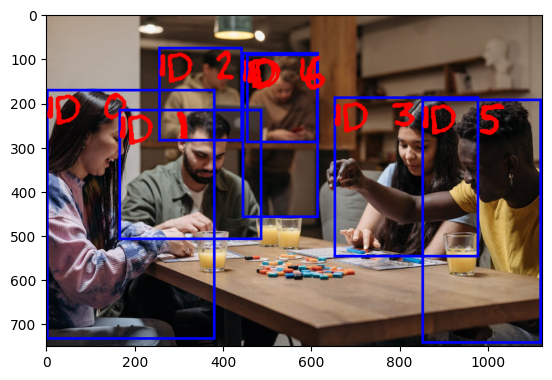

In [6]:
image = Image.open("./images/friends.jpeg")
results = yolo.predict(image)[0]

person_cls = 0
bounding_box_color = "blue"

font = ImageFont.truetype("Humor-Sans.ttf", size=100)
image_ref = image.copy()
draw = ImageDraw.Draw(image_ref)
person_boxes = [box for box in results.boxes if int(box.cls) == person_cls]
for i in range(len(person_boxes)):
    bb = person_boxes[i].xyxy[0].cpu().numpy().astype(int)
    draw.rectangle([(bb[0], bb[1]), (bb[2], bb[3])], outline=bounding_box_color, width=6)
    draw.text((bb[0], bb[1] - 10), f"ID {i}", fill="red", font=font)

plt.imshow(image_ref)
plt.show()

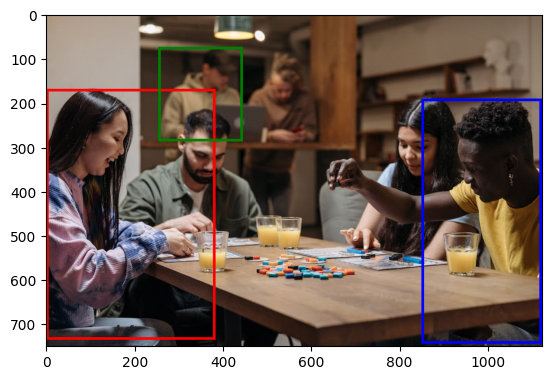

In [7]:
bounding_box_colors = ["blue", "red", "green"]
names               = ["Tom", "Julia", "Jonh"]
persons_id          = [5, 0, 2]

image_with_rectangle = image.copy()
draw = ImageDraw.Draw(image_with_rectangle)
for i, id in enumerate(persons_id):
  person_box = person_boxes[id].xyxy[0].cpu().numpy().astype(int)
  draw.rectangle(person_box.tolist(), outline=bounding_box_colors[i], width=6)

plt.imshow(image_with_rectangle)
plt.show()

### Prompt template

In [23]:
task = f"describe what Jonh, specifically, is doing?"
context = f"{', '.join(names)} are friends since high school."
max_tokens = 200
prompt_template = f"In this image, the entities enclosed in {', '.join(bounding_box_colors)} boxes are respectively called {', '.join(names)}. \
Without mentioning the bounding boxes and their color, {task}."
if len(context) > 0:
  prompt_template += f"[Optional] Give more details using the information from: {context}."

In [15]:
def prompt_result(question, image, nb_tokens=300, line_break_after=80, temperature=0.9, do_sample=True):
  conversation = [
      {

          "role": "user",
          "content": [
              {"type": "text", "text": question},
              {"type": "image"},
          ],
      },
  ]

  prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
  inputs = processor(images=image, text=prompt, return_tensors='pt').to(0, torch.float16)
  output = model.generate(**inputs, max_new_tokens=nb_tokens, temperature=temperature, do_sample=do_sample)

  llava_res = processor.decode(output[0], skip_special_tokens=True)
  match = re.search(r"ASSISTANT:\s*(.*)", llava_res)
  cleaned_text = match.group(1).strip()
  return textwrap.fill(cleaned_text, width=line_break_after)


### Without Bouding Box

John, who is one of the people sitting around the table, is holding a finger up.
It seems that he may be participating in a game related to the activity they are
all engaged in. The group is surrounding a table with multiple cups and a card
game, so John's participation might involve making a decision, signaling
something to others, or simply adding to the enjoyment of the game.


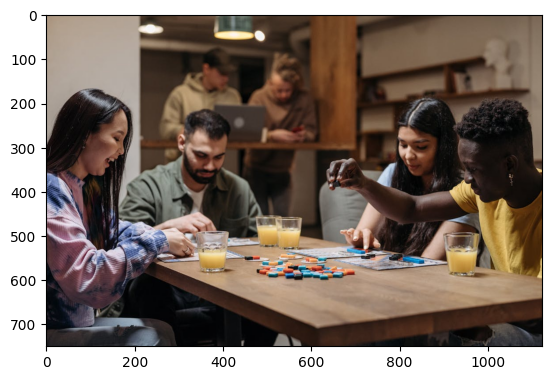

In [24]:
plt.imshow(image)
print(prompt_result(task, image))

### With bounding box

Jonh is sitting at the table with a group of friends, who are engaged in playing
with a wooden game board. It appears they are gathered for a fun and social
activity together. The table has various items on it, such as cups, bowls, and
books. There are chairs placed around the table, accommodating the friends'
seating during the game. These friends have been together since high school, so
their gatherings might involve playing games, catching up, and enjoying each
other's company.


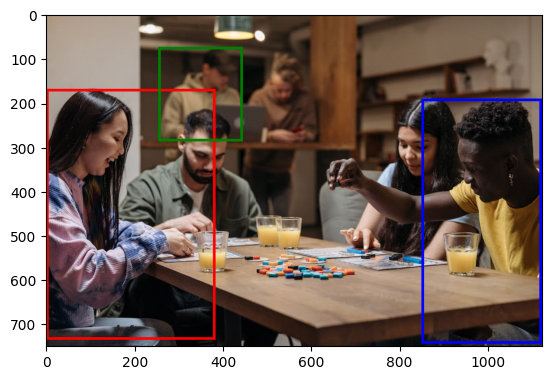

In [25]:
plt.imshow(image_with_rectangle)
print(prompt_result(prompt_template, image_with_rectangle))